# 0.0 imports

In [3]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 helper functions

In [4]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range( 1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

## 0.2 load dataset

In [6]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 data description

In [7]:
df1 = df_raw.copy()

## 1.1 rename columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 data dimension

In [9]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of cols: {}'.format(df1.shape[1]))

number of rows: 1017209
number of cols: 18


## 1.3 data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 fillout NA

In [12]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year                                 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 change data types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 descriptive statistics 

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float', 'datetime64[ns]'])

### 1.7.1 numerical attributes

In [13]:
# central tendency - mean, meadian
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 categorical attributes 

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

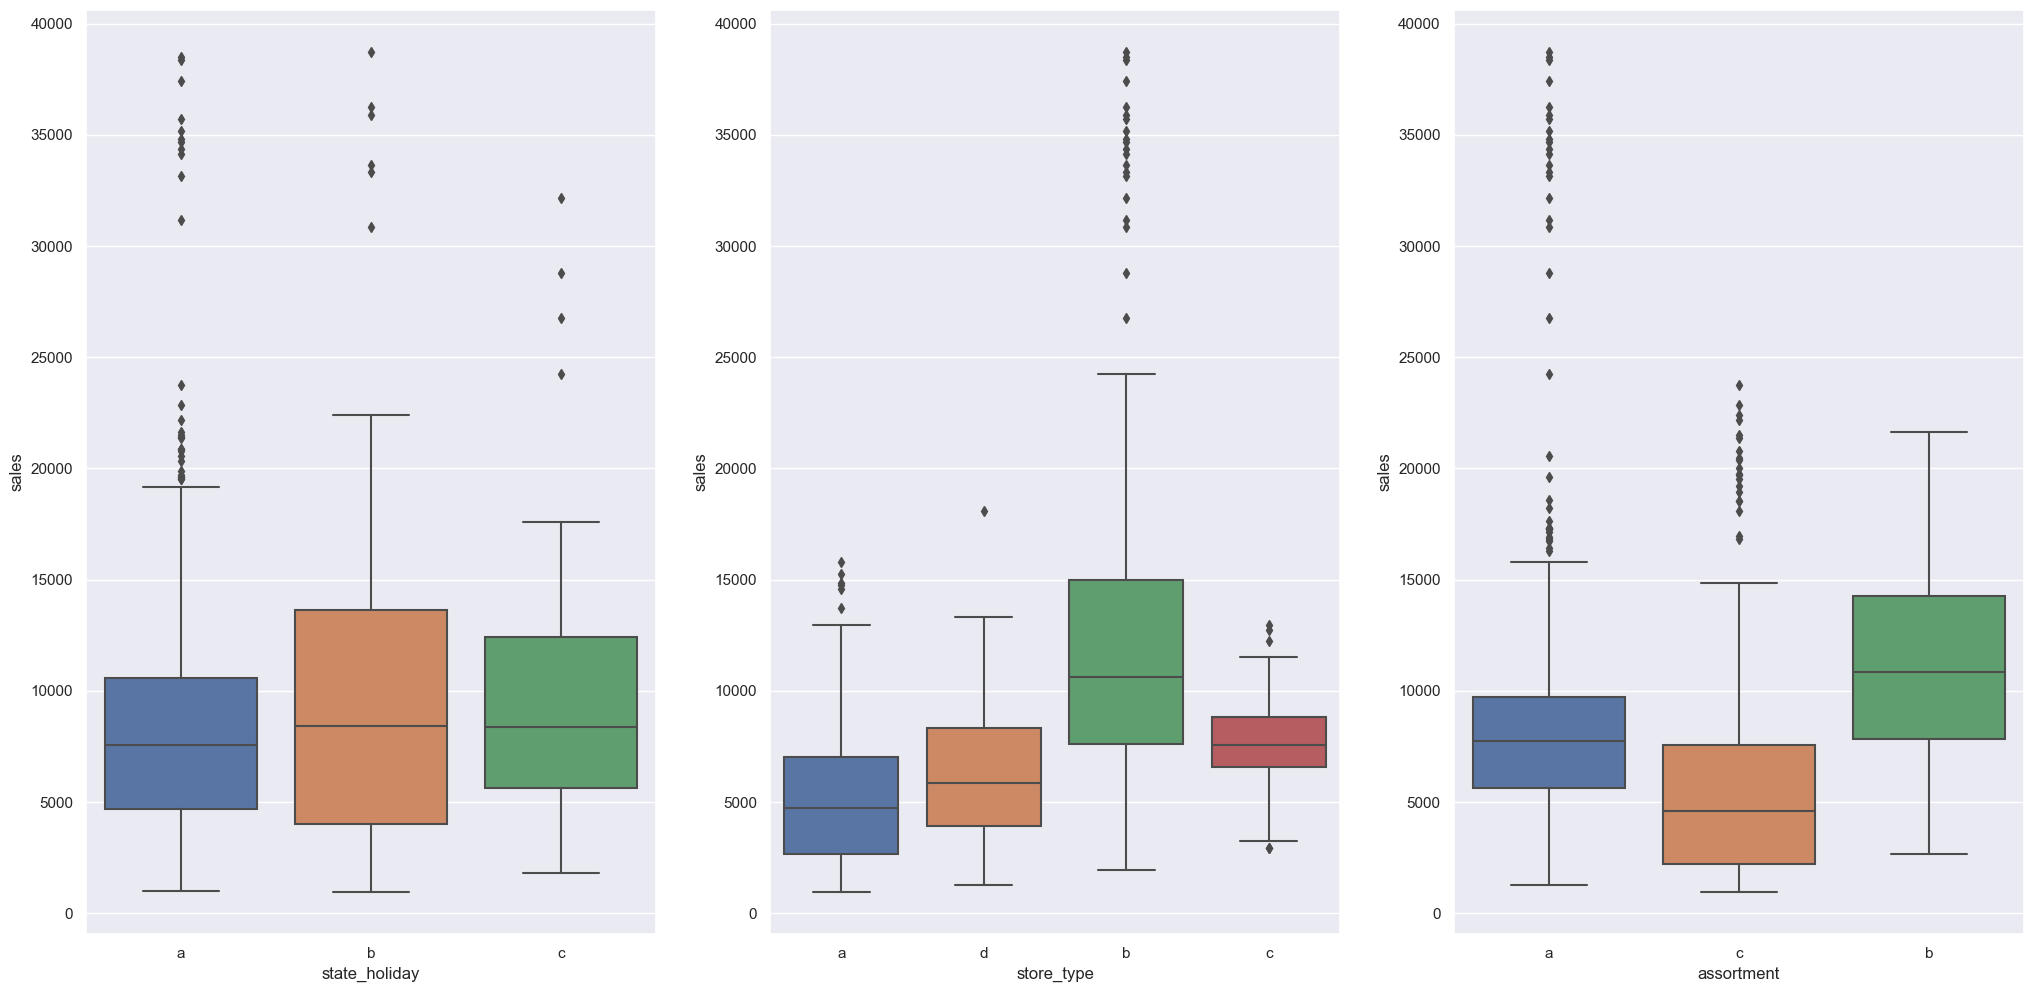

In [15]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data= aux);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2.0 feature engineering

In [14]:
df2 = df1.copy()

## 2.1 mind map

In [ ]:
Image('../img/MindMapHypothesis.png')

## 2.2 hypothesis creation

### 2.2.1 store hypothesis

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Stores with a larger size should sell more.

**4.** Stores with greater assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors that have been around longer should sell more.

### 2.2.2 product hypothesis

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower-priced products should sell more.

**5.** Stores with more aggressive promotions (larger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 time hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 final hypothesis

**1.** Stores with greater assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors that have been around longer should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 feature engineering

In [15]:
df2['year'] = df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.isocalendar().week

df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 variable filtering

In [16]:
df3 = df2.copy()

## 3.1 row filtering

In [17]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 column filtering 

In [18]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 data analysis exploration

In [19]:
df4 = df3.copy()

## 4.1 uni

### 4.1.1 response

In [ ]:
sns.distplot(df4['sales']);

### 4.1.2 numerical

In [ ]:
num_attributes.hist(bins=25);

### 4.1.3 categorical

In [ ]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 bi

### 1. Stores with greater assortments should sell more (FALSE)

In [ ]:
aux = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux);

### 2. Stores with closer competitors should sell less (FALSE)

In [ ]:
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux);

plt.subplot(1, 2, 2)
bins = list(np.arange(0, 20000, 1000))
aux['competition_binned'] = pd.cut(aux['competition_distance'], bins=bins)
aux1 = aux[['competition_binned', 'sales']].groupby('competition_binned').sum().reset_index()
sns.barplot(x='competition_binned', y='sales', data=aux1);

### 3. Stores with competitors that have been around longer should sell more (FALSE) 

In [ ]:
plt.subplot(1, 3, 1)
aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux[(aux['competition_time_month'] < 120) & (aux['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### 4.0 Stores with active promotions for longer should sell more (FALSE)

In [ ]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux[aux['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux[aux['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 6.0 Stores with more consecutive promotions should sell more (FALSE)

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax=ax)

ax.legend(labels=['traditional & extended', 'extended']);


### 7.0 Stores open during the Christmas holiday should sell more (FALSE)

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### 8.0 Stores should sell more over the years (FALSE)

In [ ]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### 9.0 Stores should sell more in the second half of the year (FALSE)

In [ ]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 10.0 Stores should sell more after the 10th of each month (TRUE)

In [ ]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux);

plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

aux['before_after'] = aux['day'].apply(lambda x: 'before_10th' if x <= 10 else 'after_10th')
aux2 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);


### 11.0 Stores should sell less on weekends (TRUE)

In [ ]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 12.0 Stores should sell less during school holidays (TRUE)

In [ ]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux);

plt.subplot(2, 1, 2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1);

### 4.2.1 summary of hypotheses

In [ ]:
from tabulate import tabulate
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],  
       ['H2', 'False', 'Medium'],  
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Medium'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'High'],
       ['H13', 'True', 'Low'],
]

print( tabulate( tab, headers='firstrow' ) )

## 4.3 multi

### 4.3.1 numerical attributes

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 categorical attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0 data preparation

In [84]:
df5 = df4.copy()

## 5.1 rescaling

In [85]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open('../parameter/year_scaler.pkl', 'wb') )

## 5.2 transformation

### 5.2.1 enconding

In [83]:
#state holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

#store type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

#assortment
assortment_dict = {'basic': 1, 'extra':2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.2.2 response variable transformation

In [23]:
df5['sales'] = np.log1p(df5['sales'])

### 5.2.3 nature transformation

In [24]:
time_columns = ['day_of_week', 'month', 'day', 'week_of_year']
periods = [7, 12, 30, 52]

for col, period in zip(time_columns, periods):
    df5[f'{col}_sin'] = np.sin(df5[col] * (2. * np.pi / period))
    df5[f'{col}_cos'] = np.cos(df5[col] * (2. * np.pi / period))

# 6.0 feature selection

In [25]:
df6 = df5.copy()

## 6.1 split dataframe into train and test

In [26]:
cols_drop = ['week_of_year', 'day', 'month', 'competition_since', 'day_of_week', 'promo_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

In [27]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [28]:
#train dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 borutas as feature selector

In [ ]:
# # train and test dataset for boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# #define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 best features from boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# #best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

## 6.3 manual feature selection

In [29]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 machine learning modeling

## 7.0.1  split train and test

In [30]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1 average model

In [36]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 linear regression

In [41]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 cross validation

In [60]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 linear regression regularized

In [46]:
#model
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


### 7.3.1 cross validation

In [61]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2088.88 +/- 327.01,0.3 +/- 0.01,2988.6 +/- 499.57


## 7.4 random forest regressor

In [54]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.014263,0.099793,1009.741947


### 7.4.1 cross validation

In [62]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,832.52 +/- 216.54,0.12 +/- 0.02,1249.27 +/- 316.17


## 7.5 xgboost regressor

In [31]:
#model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,860.433707,0.128868,1232.368137


### 7.5.1 cross validation

In [63]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


## 7.6 compare model's performance

## 7.6.1 single performance

In [53]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.056420,0.099762,1008.977548
0,XGBoost Regressor,860.433707,0.128868,1232.368137
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


## 7.6.2 real performance - cross validation

In [67]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2088.88 +/- 327.01,0.3 +/- 0.01,2988.6 +/- 499.57
0,Random Forest Regressor,832.52 +/- 216.54,0.12 +/- 0.02,1249.27 +/- 316.17
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


# 8.0 hyperparameter fine tunning

## 8.1 random search

In [37]:
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [39]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])
       
# final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1042.47 +/- 121.23,0.15 +/- 0.01,1495.71 +/- 175.42
0,XGBoost Regressor,1041.38 +/- 124.94,0.15 +/- 0.01,1495.83 +/- 178.04
0,XGBoost Regressor,1319.22 +/- 133.77,0.18 +/- 0.01,1903.81 +/- 172.68
0,XGBoost Regressor,1054.11 +/- 133.92,0.14 +/- 0.01,1527.86 +/- 193.2
0,XGBoost Regressor,1645.08 +/- 161.45,0.23 +/- 0.01,2372.78 +/- 211.91


## 8.2 final model

In [50]:
param_tuned = {
    'n_estimators': 4000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [51]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,743.850362,0.110497,1077.677541


# 9.0 interpretation of the error

In [56]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 business performance

In [65]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE/MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [66]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,171600.687500,171242.847333,171958.527667,357.840167,0.082446
1,2,191830.921875,191334.585007,192327.258743,496.336868,0.105067
2,3,268824.812500,268166.053612,269483.571388,658.758888,0.091637
3,4,337673.000000,336733.178988,338612.821012,939.821012,0.089043
4,5,174536.078125,174115.284797,174956.871453,420.793328,0.089933


<Axes: xlabel='store', ylabel='MAPE'>

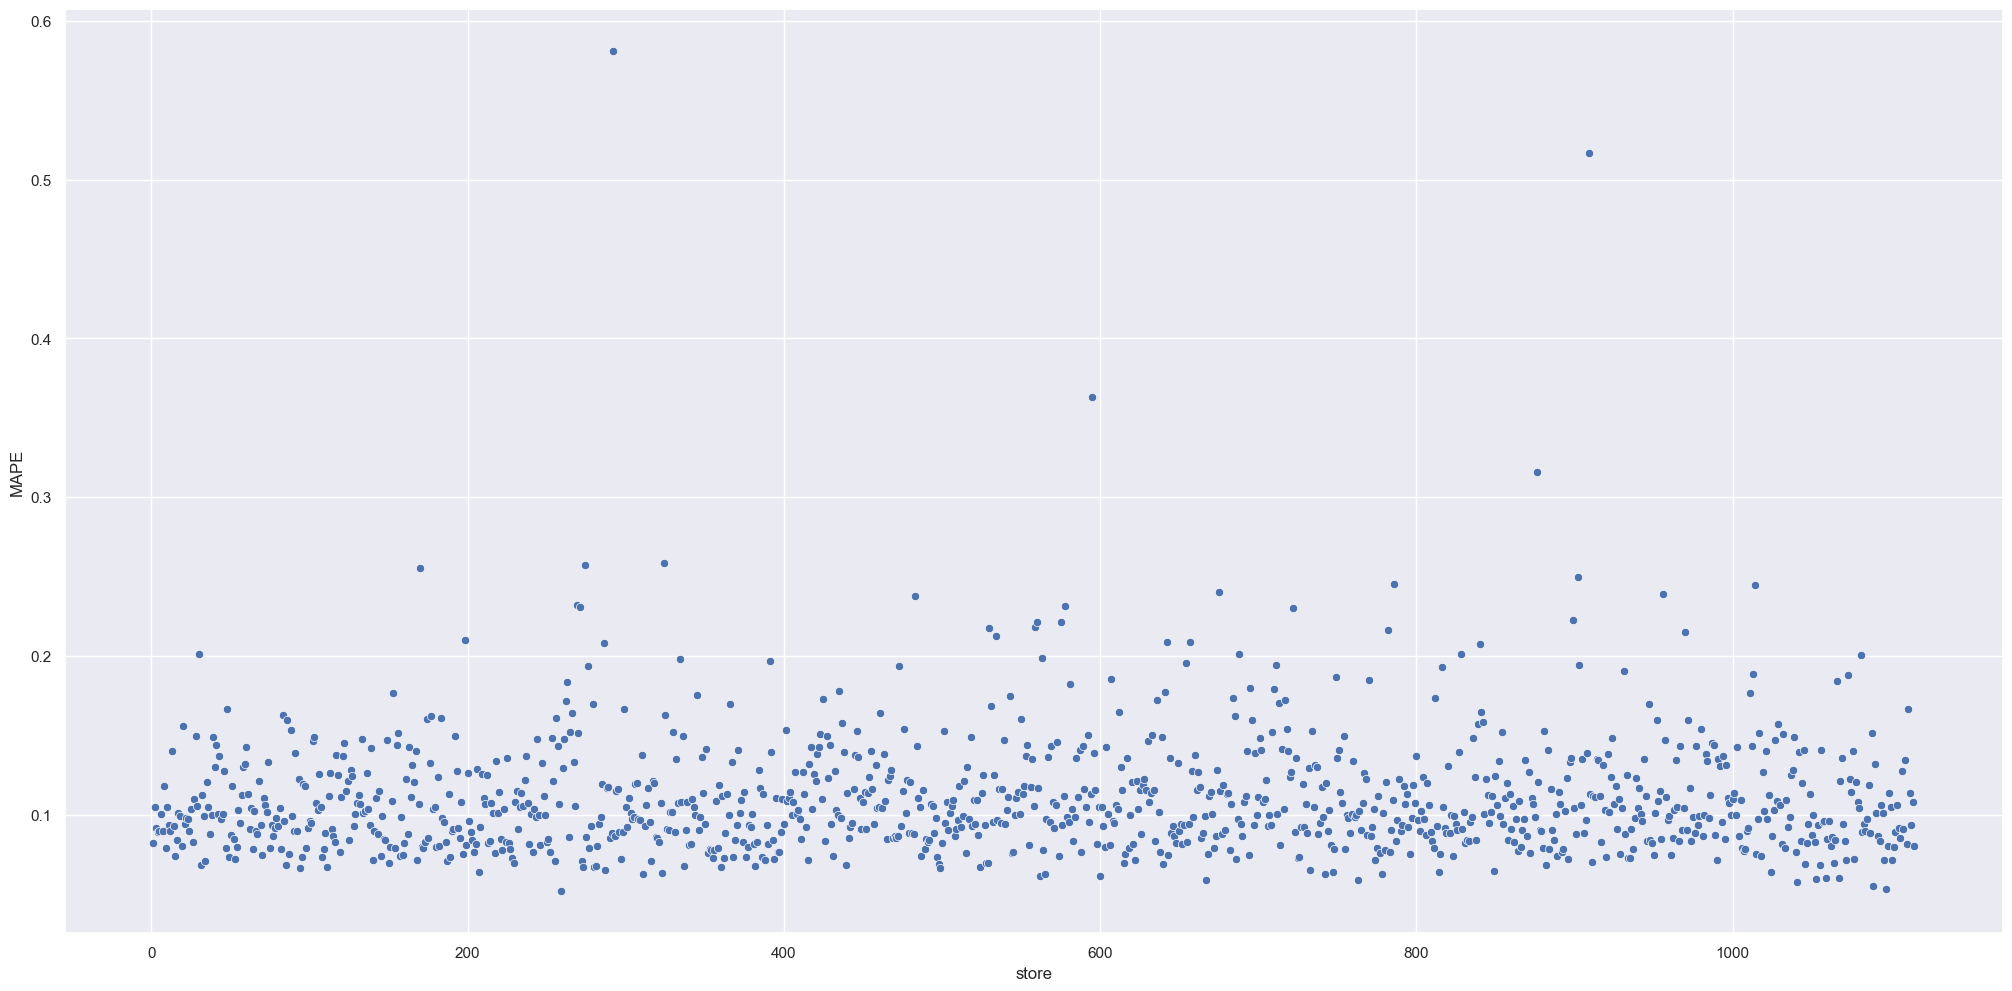

In [67]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 total performance

In [72]:
df93 = df92[['predictions', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93.head()

,scenario,values
0,predictions,"R$285,729,632.00"
1,best_scenario,"R$286,562,362.82"
2,worst_scenario,"R$284,896,914.85"


## 9.3 machine learning performance

In [73]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

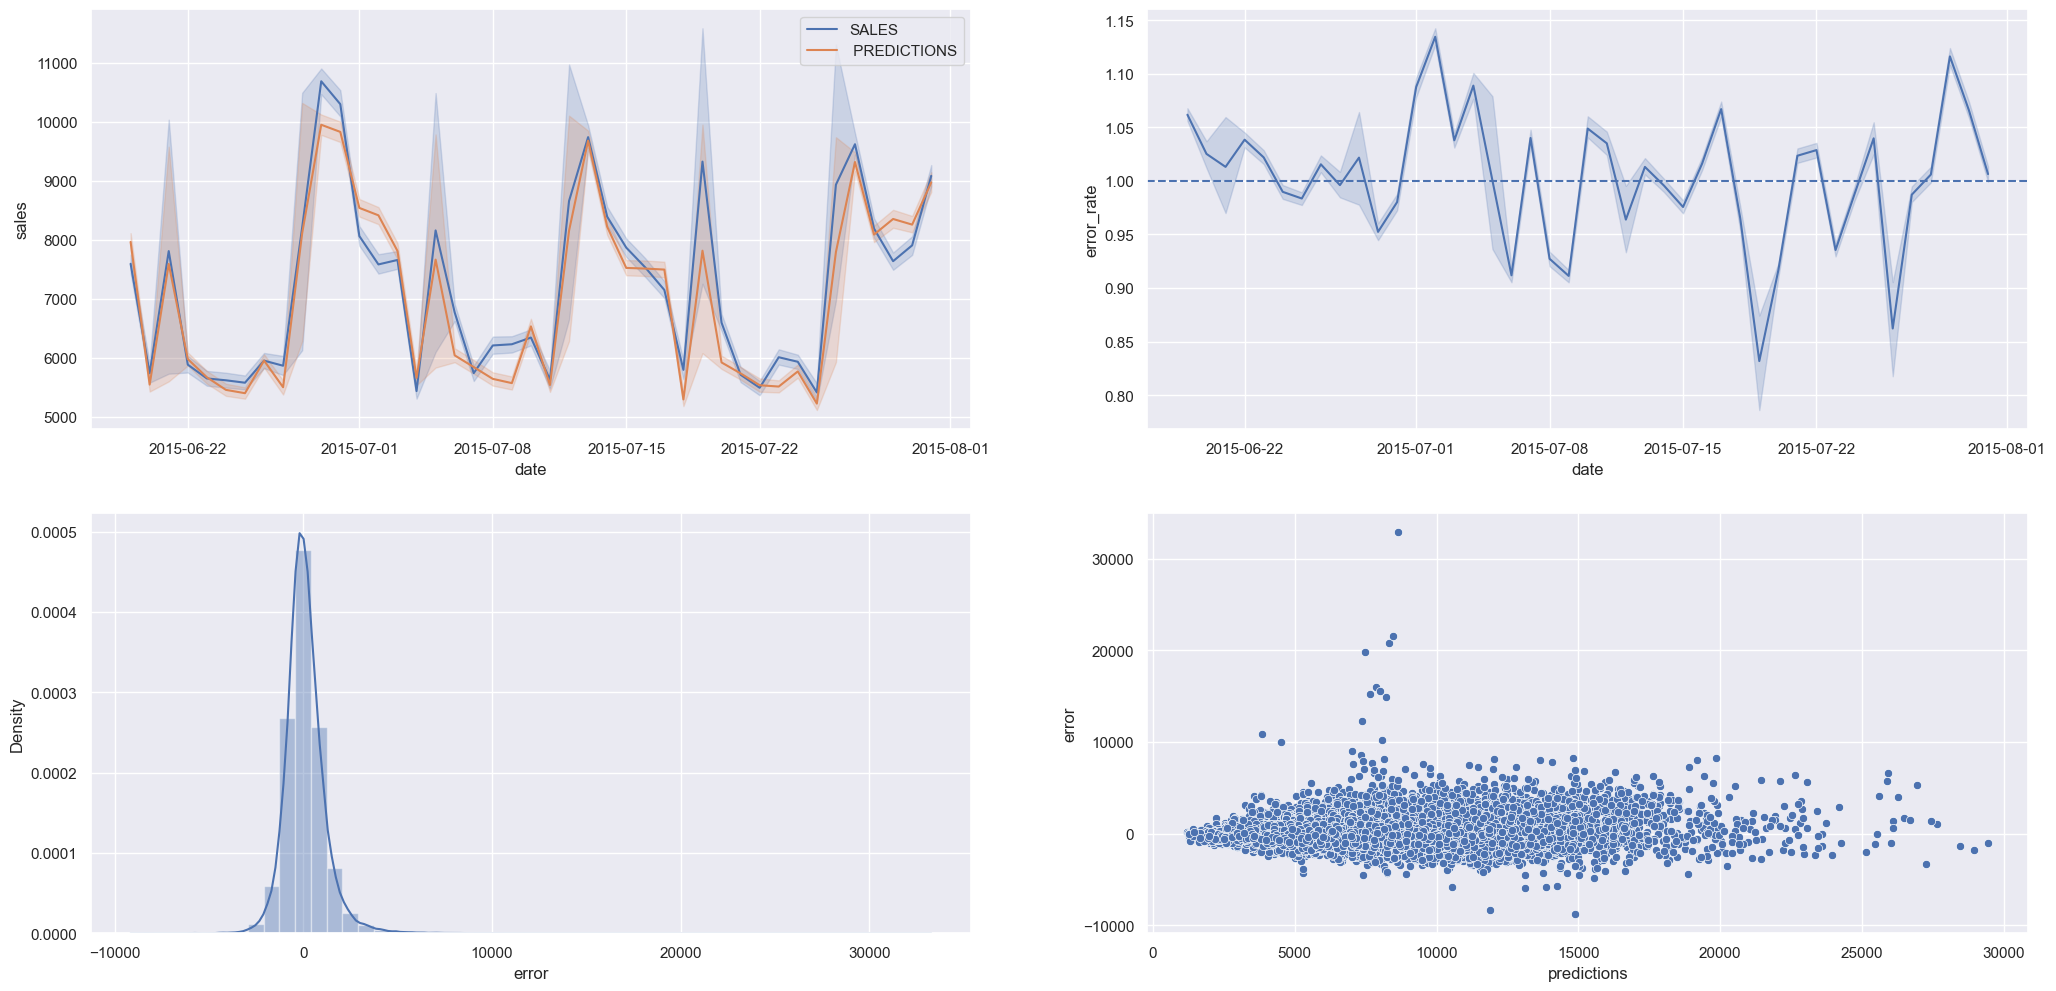

In [76]:
plt.subplot(2, 2, 1) 
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label=' PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3) 
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9);

# 10.0 deploy model to production

In [54]:
#trained model
pickle.dump(model_xgb_tuned, open('/Users/raphael/Documents/repos/rossmann_sales/model/model_rossmann.pkl', 'wb'))

## 10.1 rossmann class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/Users/raphael/Documents/repos/rossmann_sales/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        df2 = df2[df2['open'] != 0]

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 api handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/raphael/Documents/repos/rossmann_sales/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3 api tester

In [116]:
#load test dataset
df10 = pd.read_csv('../data/test.csv')

In [117]:
#merge
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([3, 15, 22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [118]:
# converto to json
data = json.dumps(df_test.to_dict(orient='records'))

In [119]:
# API CALL
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [120]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [122]:
d2 = d1[[ 'store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i, 'prediction']))

store number 3 will sell R$229,665.80 in the next 6 weeks
store number 15 will sell R$426,315.82 in the next 6 weeks
store number 22 will sell R$161,355.52 in the next 6 weeks
